In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stat
# import warnings

# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [21]:
data = pd.read_csv('oasis_cross-sectional.csv')
data.head(7)

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN
5,OAS1_0006_MR1,F,R,24,NaN,NaN,NaN,NaN,1131,0.862,1.551,NaN
6,OAS1_0007_MR1,M,R,21,NaN,NaN,NaN,NaN,1516,0.830,1.157,NaN


In [22]:
def remove_high_nan(df, ratio = 0.65):
    for i in df.columns:
        if df[i].isnull().mean() > 0.65:
            df.drop(i, axis = 1, inplace = True)

remove_high_nan(data)

Text(0.5, 1.0, 'Null values we have to handle')

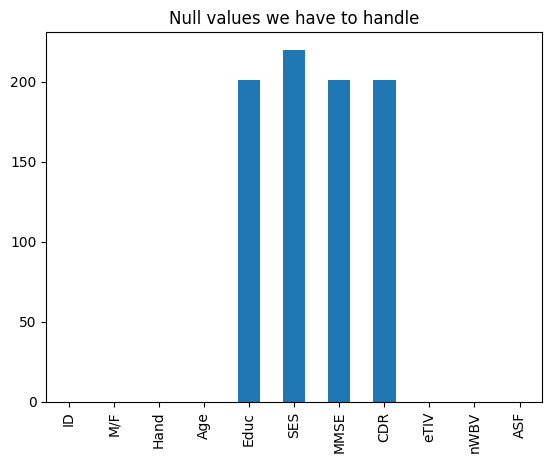

In [23]:
data_2 = data.copy()
data.isnull().sum().plot(kind = 'bar')
plt.title('Null values we have to handle')

In [24]:
def add_label(data, attr, name_notnan = 'Training', name_nan = 'Predict'):
    null_pos = data[attr][data[attr].isnull()].index
    data['Label'] = name_notnan
    data['Label'].iloc[null_pos] = name_nan

def mean_median_mode_imputation(data, kind = 'mean'):
    if kind == 'mean':
        return data.fillna(np.mean(data.dropna()))
    elif kind == 'median':
        return data.fillna(np.median(data.dropna()))
    
def mode_imputation(data):
    return data.fillna(data.mode().iloc[0])

In [25]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

def Miss_forest_impute(data, attr, dtype):
    train_data, test_data = data[data['Label'] == 'Training'], data[data['Label'] == 'Predict']

    Y = data[[attr]]
    X = data.drop([attr, 'Label'], axis = 1)

    y_train = train_data[[attr]]
    x_train = train_data.drop([attr, 'Label'], axis = 1)

    y_test = test_data[[attr]]
    x_test = test_data.drop([attr, 'Label'], axis = 1)

    if dtype == 'Continuous':
        model = RandomForestRegressor()
        model.fit(X, Y)
    elif dtype == 'Categorical':
        model = RandomForestClassifier()
        model.fit(X, Y)

    y_pred = model.predict(x_test)

    return y_pred, Y[data['Label'] == 'Predict'].index

In [26]:
data = pd.get_dummies(data)
not_null_attr = data.isnull().sum()[data.isnull().sum() == 0].index
null_attr = data.isnull().sum()[data.isnull().sum() > 0].index
attr = {}
njobs = 10

for i in null_attr:
    df = pd.concat([data[not_null_attr], data[i]], axis = 1)
    add_label(df, i)

    if i=='CDR' or i=='MMSE':
        df[i] = mean_median_mode_imputation(df[i], 'mean')

        for job in range(njobs):
            y_pred, index = Miss_forest_impute(df, i, 'Continuous')
            df[i].iloc[index] = y_pred
    else:
        df[i] = mode_imputation(df[i])

        for job in range(njobs):
            y_pred, index = Miss_forest_impute(df, i, 'Categorical')
            df[i].iloc[index] = y_pred

    attr[i] = df[i]

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConvers

In [27]:
data_2.drop(null_attr, axis = 1, inplace = True)

In [28]:
data_final = pd.concat([data_2, pd.DataFrame(attr)], axis = 1)
data_final.head(7)

,ID,M/F,Hand,Age,eTIV,nWBV,ASF,Educ,SES,MMSE,CDR
0,OAS1_0001_MR1,F,R,74,1344,0.743,1.306,2.0,3.0,29.000000,0.000000
1,OAS1_0002_MR1,F,R,55,1147,0.810,1.531,4.0,1.0,29.000000,0.000000
2,OAS1_0003_MR1,F,R,73,1454,0.708,1.207,4.0,3.0,27.000000,0.500000
3,OAS1_0004_MR1,M,R,28,1588,0.803,1.105,2.0,2.0,27.137935,0.283066
4,OAS1_0005_MR1,M,R,18,1737,0.848,1.010,2.0,2.0,27.063830,0.285106
5,OAS1_0006_MR1,F,R,24,1131,0.862,1.551,2.0,2.0,27.064205,0.285106
6,OAS1_0007_MR1,M,R,21,1516,0.830,1.157,2.0,2.0,27.063830,0.285106


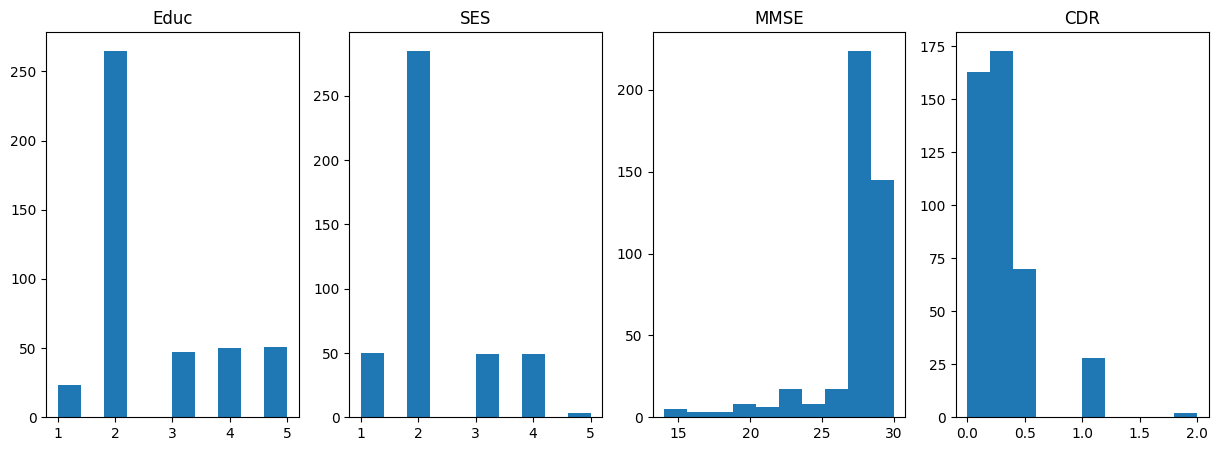

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=len(null_attr), figsize=(15, 5))

for pos, i in enumerate(null_attr):
    ax[pos].hist(data_final[i])
    ax[pos].set_title(i)

In [30]:
data_final.to_csv('oasis_cross-sectional_imputed.csv', index = False)